In [4]:
# Controls

# Loading and Saving Routines
NEW_ROUTINES = False
SAVE_ROUTINES = False

# General Controls
NEW_L_MAX = 3
FOLDER_PATH = 'data/variance-analysis/'
MONTE_CARLO_PATH = 'data/monte-carlo-trials/'
FIGURE_FOLDER_PATH = 'data/figures/'
MAP_FOLDER_PATH = ''
NAMES = ['standard_model_dipoles', 'same_cls', 'same_cls_pref']
N_SIMS = [10000, 10000, 1000]

In [5]:
import numpy as np
import healpy as hp
import pandas as pd
import seaborn as sns
import warnings
import matplotlib
import matplotlib.ticker as plticker
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
from greatcirclelibrary import *
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [13, 9]
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 20})

In [6]:
def amplitude_anomaly_table(alms_sims, file_name):
    
    simulated_dipole_cls = np.zeros([alms_sims.shape[0], alms_sims.shape[1]])
    real_preferred_dipole_cls = np.zeros(alms_sims.shape[0])
    
    for i in range(alms_sims.shape[0]):
        real_preferred_dipole_cls[i] = hp.alm2cl(monte_carlo_alms_pref[i])[1]
        for j in range(alms_sims.shape[1]):
            simulated_dipole_cls[i][j] = hp.alm2cl(alms_sims[i][j])[1]
    
    cols = ['Map', 'Simulations with Larger Dipole Amplitudes']
    data = []

    for i in range(len(alms_sims)):
        entry_name = map_names[i]
        entries = []
        entries.append(sum(1 for j in simulated_dipole_cls[i] if j >= real_preferred_dipole_cls[i]))
        data.append((entry_name, int(entries[0])))

    df = pd.DataFrame(data, columns = cols, index = np.full(len(alms_sims),''))

    display(df)

In [27]:
def variance_table(vars_of_statistics):
    
    cols = ['Map', 'Variance of Great Circle Variances']
    data = []

    for i in range(len(vars_of_statistics)):
        entry_name = map_names[i]
        entries = []
        entries.append(vars_of_statistics[i])
        data.append((entry_name, int(entries[0])))

    df = pd.DataFrame(data, columns = cols, index = np.full(len(vars_of_statistics),''))
    
    display(df)

In [28]:
def variance_anomaly_table(vars_of_statistics):
    
    cols = ['Map', 'Simulations with Smaller Variance of Great Circle Variances']
    data = []
    
    for i in range(len(vars_of_statistics)):
        entry_name = map_names[i]
        entries = []
        entries.append(sum(1 for j in vars_of_statistics[i] if j <= vars_of_statistics_maps_preferred[i]))
        data.append((entry_name, int(entries[0])))
    
    df = pd.DataFrame(data, columns = cols, index = np.full(len(vars_of_statistics),''))

    display(df)

In [9]:
map_paths = ['COM_CompMap_CMB-nilc_2048_R1.20.fits',    # 0 - NILC
             'COM_CompMap_CMB-smica_2048_R1.20.fits',   # 1 - SMICA
             'COM_CompMap_CMB-sevem_2048_R1.12.fits',   # 2 - SEVEM
             'COM_CompMap_CMB-commrul_2048_R1.00.fits'] # 3 - COMMRUL

map_paths = MAP_FOLDER_PATH + np.array(map_paths, dtype=np.object)
map_names = ['NILC', 'SMICA', 'SEVEM', 'COMMANDER']

In [10]:
alms_real_no_dipole_or_monopole = preprocess_maps(map_paths, NEW_L_MAX)

In [17]:
monte_carlo_alms = np.load(MONTE_CARLO_PATH + 'monte_carlo_alms.npy')
monte_carlo_alms_pref = np.load(MONTE_CARLO_PATH + 'monte_carlo_alms_pref.npy')
monte_carlo_var_of_vars = np.load(MONTE_CARLO_PATH + 'monte_carlo_var_of_vars.npy')
monte_carlo_var_of_vars_pref = np.load(MONTE_CARLO_PATH + 'monte_carlo_var_of_vars_pref.npy')

monte_carlo_dipole_cls = np.zeros([monte_carlo_alms.shape[0], monte_carlo_alms.shape[1]])

for i in range(monte_carlo_dipole_cls.shape[0]):
    for j in range(monte_carlo_dipole_cls.shape[1]):
        monte_carlo_dipole_cls[i][j] = hp.alm2cl(monte_carlo_alms[i][j])[1]

In [19]:
def dipole_amplitude_table():
    
    real_preferred_dipole_cls = np.zeros(monte_carlo_alms_pref.shape[0])
    
    for i in range(monte_carlo_alms_pref.shape[0]):
        real_preferred_dipole_cls[i] = np.sqrt(3 * hp.alm2cl(monte_carlo_alms_pref[i])[1]) / 2
    
    cols = ['Map', 'Dipole Amplitude (µK)']
    data = []

    for i in range(len(monte_carlo_alms_pref)):
        entry_name = map_names[i]
        entries = []
        entries.append(real_preferred_dipole_cls[i])
        data.append((entry_name, round(entries[0], 2)))

    df = pd.DataFrame(data, columns = cols, index = np.full(len(monte_carlo_alms_pref),''))

    display(df)
    

In [20]:
dipole_amplitude_table()

,Map,Dipole Amplitude (µK)
,NILC,17.58
,SMICA,18.15
,SEVEM,18.14
,COMMANDER,18.95


In [21]:
def save_routine(name, simulation_method, original_alms, pref_versions, n):
    
    sims = np.zeros([len(original_alms), n, original_alms.shape[1]], dtype='complex')
    vars_of_statistics = np.zeros([len(original_alms), n])
    
    gc_pix_1 = generate_gcs()
    gc_pix_2 = generate_gcs()
    
    for i in range(len(original_alms)):

        sims[i] = simulation_method(original_alms[i], n)
        
        if pref_versions:
            sims[i] = get_pref_versions(sims[i], gc_pix_1)
            print('Complete Minimization ' + str(i + 1) + ' Done.')
        else:
            vars_of_statistics[i] = np.var(multi_gc_vars(gc_pix_1, sims[0][i]), axis=1, ddof=1)

    if SAVE_ROUTINES:
        np.save(FOLDER_PATH + 'alms_sims_' + name + '.npy', sims)
        
        if not pref_versions:
            np.save(FOLDER_PATH + 'vars_of_vars_sims_' + name + '.npy', vars_of_statistics)
    
    return sims, vars_of_statistics

In [22]:
def load_routine(name):

    return np.load(FOLDER_PATH + 'alms_sims_' + name + '.npy'), np.load(FOLDER_PATH + 'vars_of_vars_sims_' + name + '.npy')

In [23]:
vars_of_statistics_maps = np.mean(monte_carlo_var_of_vars.T, axis=1)
vars_of_statistics_maps_preferred = np.mean(monte_carlo_var_of_vars_pref.T, axis=1)

In [29]:
variance_table(vars_of_statistics_maps)

,Map,Variance of Great Circle Variances
,NILC,17998
,SMICA,23364
,SEVEM,18216
,COMMANDER,20316


In [30]:
variance_table(vars_of_statistics_maps_preferred)

,Map,Variance of Great Circle Variances
,NILC,9308
,SMICA,11704
,SEVEM,9247
,COMMANDER,12206


In [31]:
if NEW_ROUTINES:
    alms_sims_standard_model_dipoles, vars_of_vars_sims_standard_model_dipoles = save_routine(NAMES[0], generate_standard_dipole_sims, alms_real_no_dipole_or_monopole, False, N_SIMS[0])
else:
    alms_sims_standard_model_dipoles, vars_of_vars_sims_standard_model_dipoles = load_routine(NAMES[0])

In [32]:
def standard_model_dipoles_variance_plot_with_inset(vars_of_statistics_1, vars_of_statistics_2, file_name):
    sns.set_style('whitegrid')
    max_value_1 = max(vars_of_statistics_1.flatten()) + 1000
    max_value_2 = max(vars_of_statistics_2.flatten()) + 900
    min_value_2 = min(vars_of_statistics_2.flatten()) - 900
    colors=sns.color_palette('Paired')
    
    fig, ax = plt.subplots()
    
    for i in range(4):
        n, bins, _ = ax.hist(vars_of_statistics_1[i], cumulative=True, density=True, range=(0,max_value_1), bins = 1000, alpha = 0.0)
        my_histr = []
        for j in range(len(bins) - 1):
            my_histr.append((bins[j + 1] + bins[j])/2)
        ax.plot(my_histr, n, color=colors[2*i+1], label=map_names[i], alpha=0.8)
        ax.axvline(np.mean(vars_of_statistics_2[i]), color=colors[2*i+1], alpha=0.8, ls='--')
        ax.axhline(0, color=[0.91, 0.91, 0.91], linewidth=2)
        
    ax.set_xlabel(r'$\mathcal{S}$ $(\mu K^4)$')
    ax.set_xlim([0, 200000])
    
    ax.set_ylabel('Cumulative Probability Density')
    ax.set_yscale('log')
    ax.set_ylim([0.05, 1])
    my_ticks = [0.050, 0.0750, 0.100, 0.250, 0.500, 0.750, 1.000]
    ax.set_yticks(my_ticks)
    
    my_ticks_str = ['0.050', '0.075', '0.100', '0.250', '0.500', '0.750', '1.000']
    ax.set_yticklabels(my_ticks_str)
    
    ax.legend(fontsize=20, bbox_to_anchor=(1, 0.948))

    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax, [0.36,0.114,0.5,0.5])
    ax2.set_axes_locator(ip)

    for i in range(4):
        n, bins, _ = ax2.hist(vars_of_statistics_2[i], density=True, range=(min_value_2,max_value_2), color=colors[2*i+1], bins = 30, alpha = 0.0)
        my_histr = []
        for j in range(len(bins) - 1):
            my_histr.append((bins[j + 1] + bins[j])/2)
        ax2.plot(my_histr, n, color=colors[2*i+1], label=map_names[i], alpha=0.8)
        ax2.axvline(np.mean(vars_of_statistics_2[i]), color=colors[2*i+1], alpha=0.8, ls='--')

    ax2.axhline(0, color=[0.91, 0.91, 0.91], linewidth=2)
    ax2.set_xlim([min_value_2, max_value_2])
    ax2.set_xlabel(r'$s^2$ ($\mu K^4$)')
    ax2.set_ylabel('Probability Density')
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    my_ticks = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025]
    ax2.set_yticks(my_ticks)

        
    plt.savefig(file_name)
    plt.show()

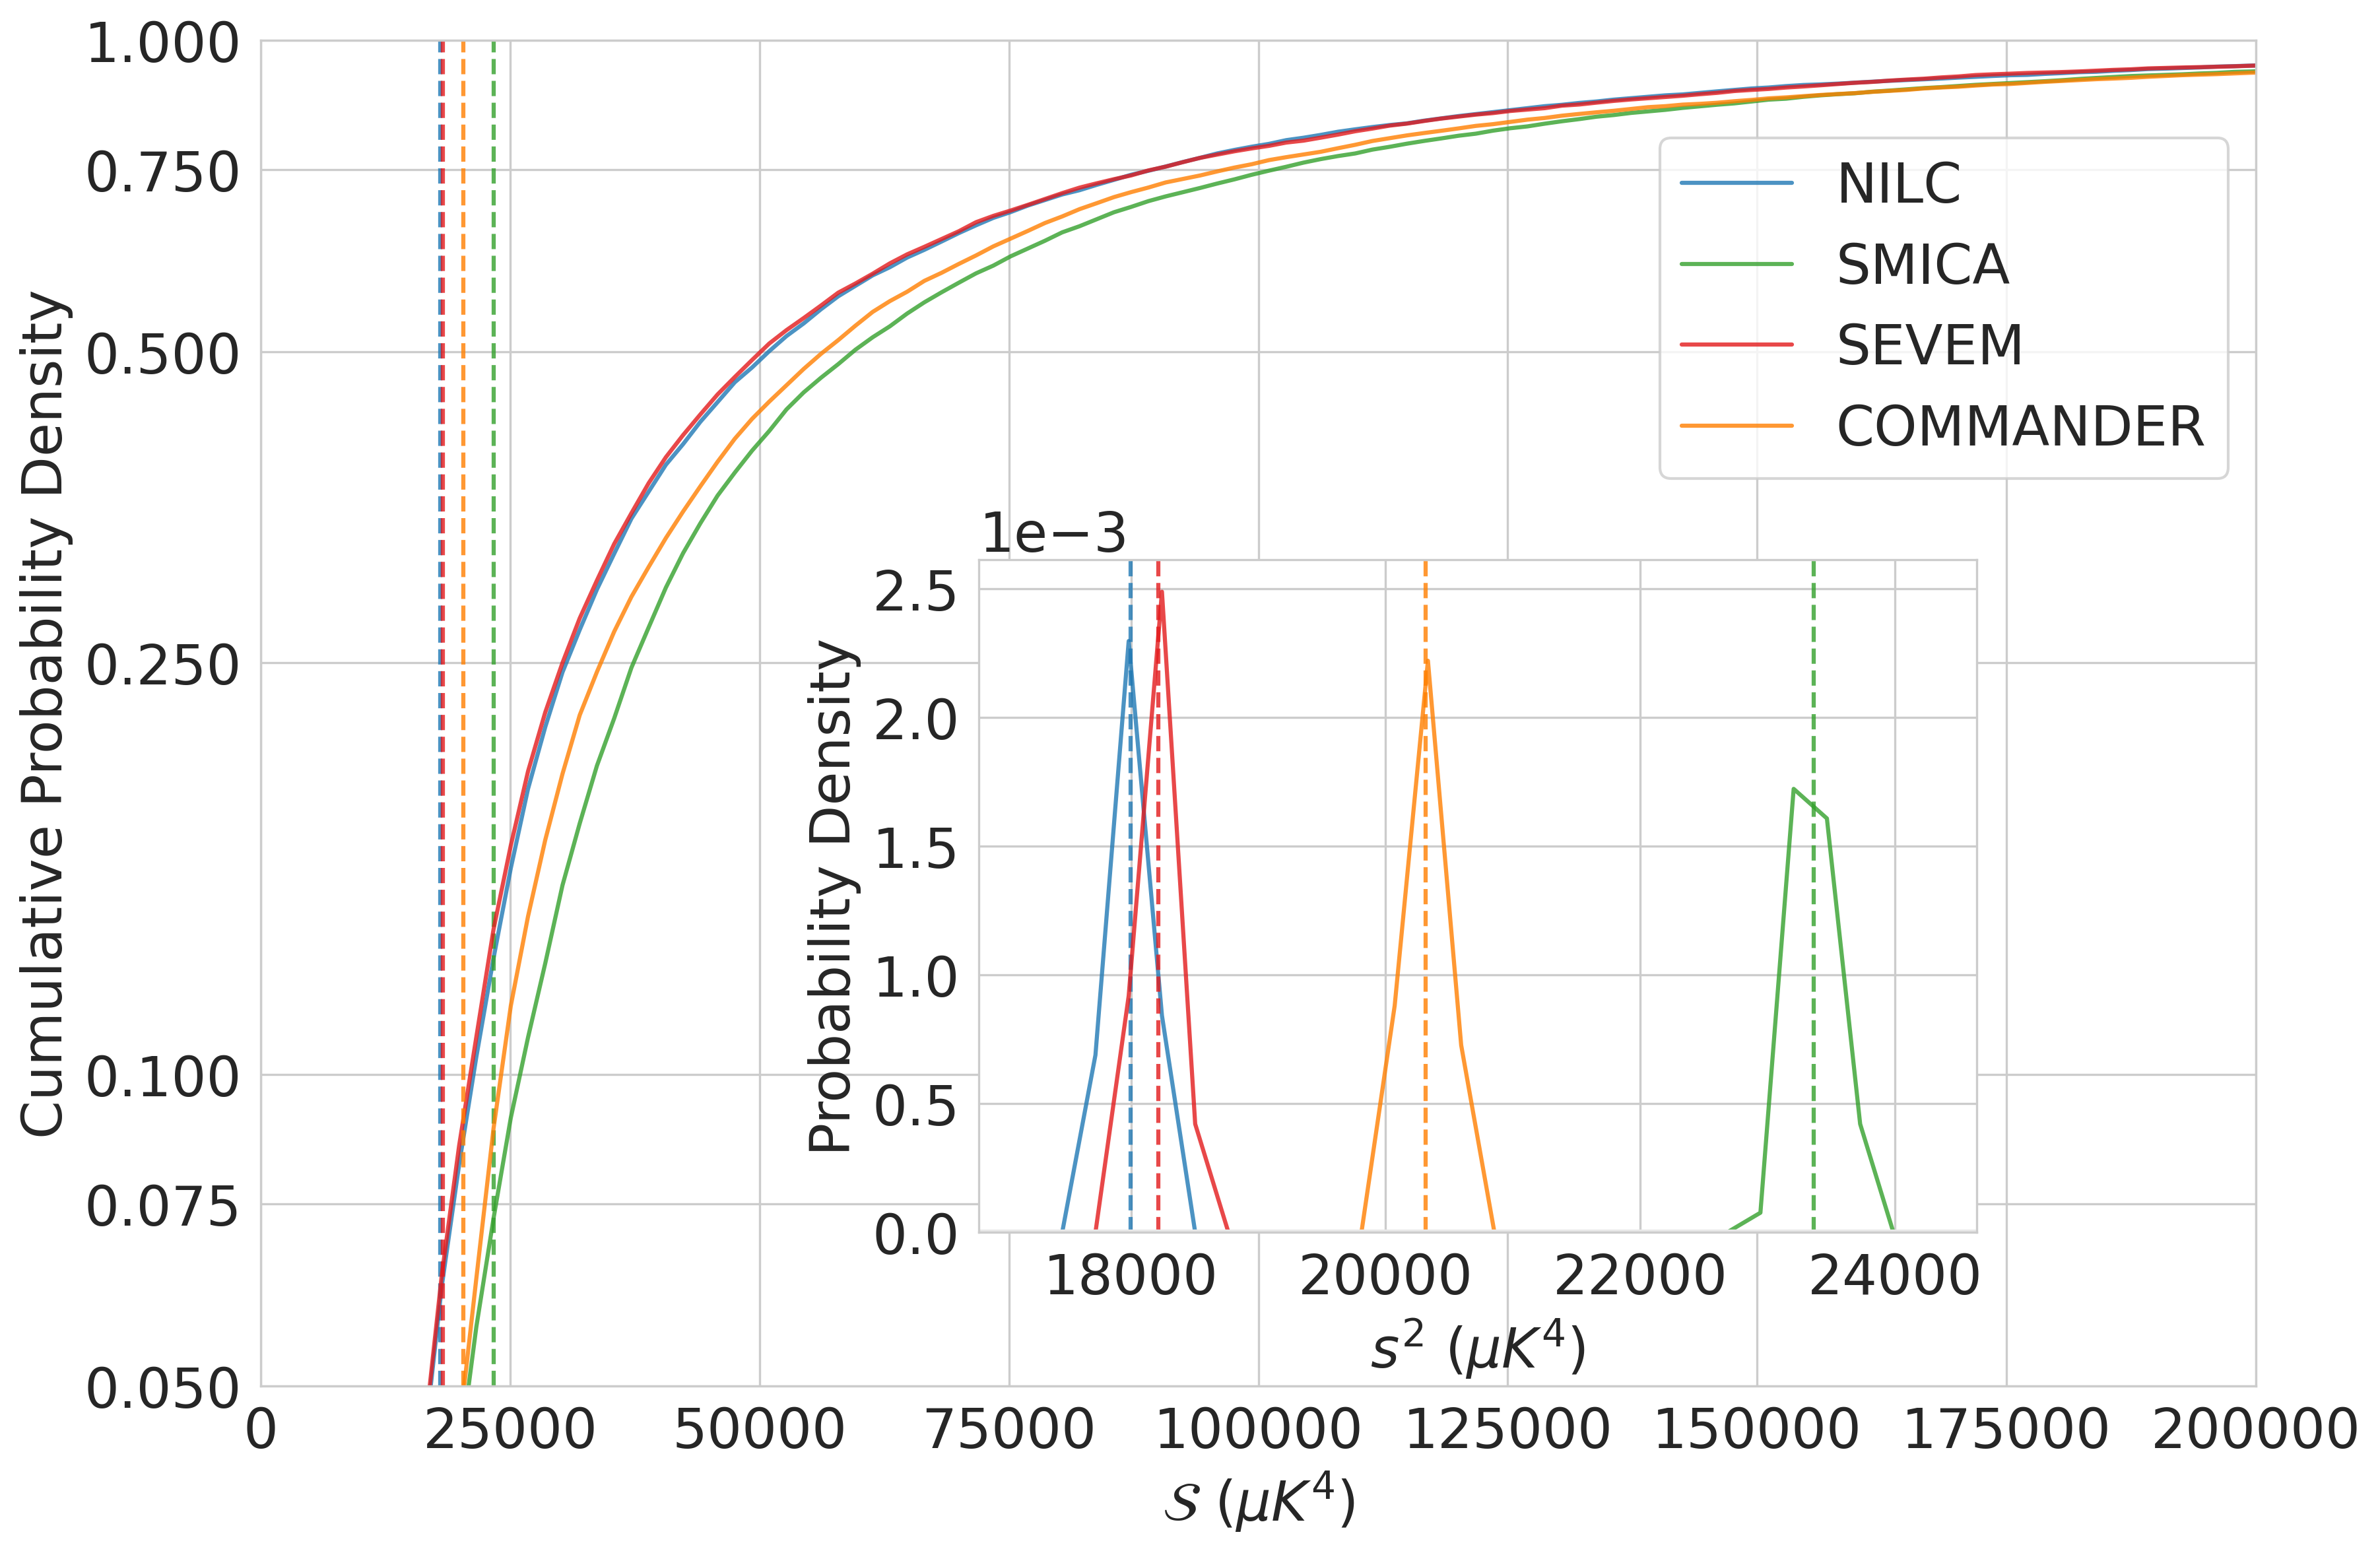

In [26]:
my_file_name = FIGURE_FOLDER_PATH + 'standard.png'
standard_model_dipoles_variance_plot_with_inset(vars_of_vars_sims_standard_model_dipoles[0], monte_carlo_var_of_vars.T, my_file_name)

In [34]:
if NEW_ROUTINES:
    alms_sims_same_cls, vars_of_vars_sims_same_cls = save_routine(NAMES[1], generate_same_cl_sims, monte_carlo_alms_pref, False, N_SIMS[1])
else:
    alms_sims_same_cls, vars_of_vars_sims_same_cls = load_routine(NAMES[1])

In [37]:
def same_cls_variance_plot_with_inset(vars_of_statistics_1, vars_of_statistics_2, file_name):
    sns.set_style('whitegrid')
    max_value_1 = max(vars_of_statistics_1.flatten()) + 1000
    max_value_2 = max(vars_of_statistics_2.flatten()) + 900
    min_value_2 = min(vars_of_statistics_2.flatten()) - 900
    colors=sns.color_palette('Paired')
    
    fig, ax = plt.subplots()
    
    for i in range(4):
        n, bins, _ = ax.hist(vars_of_statistics_1[i], cumulative=True, density=True, range=(0,max_value_1), bins = 100, alpha = 0.0)
        my_histr = []
        for j in range(len(bins) - 1):
            my_histr.append((bins[j + 1] + bins[j])/2)
        ax.plot(my_histr, n, color=colors[2*i+1], label=map_names[i], alpha=0.8)
        ax.axvline(np.mean(vars_of_statistics_2[i]), color=colors[2*i+1], alpha=0.8, ls='--')
        ax.axhline(0, color=[0.91, 0.91, 0.91], linewidth=2)
        
    ax.set_xlabel(r'$\mathcal{S}$ $(\mu K^4)$')
    ax.set_xlim([0, 80000])
    
    ax.set_ylabel('Cumulative Probability Density')
    ax.set_yscale('log')
    ax.set_ylim([0.001, 1])
    
#     my_ticks = [0.001, 0.0025, 0.005, 0.0100, 0.025, 0.0500, 0.1, 0.25, 0.50, 1.000]
    my_ticks = [0.001, 0.003, 0.0100, 0.03, 0.1, 0.3, 1.000]
    my_ticks = [0.0001, 0.0003, 0.001, 0.003, 0.0100, 0.03, 0.1, 0.3, 1.000]
    ax.set_yticks(my_ticks)
    
    ax.set_yticklabels(map(str, my_ticks))
    
    my_ticks_str = ['0.0010', '0.0025', '0.0050', '0.0100', '0.0250', '0.0500', '0.1000', '0.2500', '0.5000', '1.0000']
#     my_ticks_str = [r'$10^{-3}$', r'$3 \cdot 10^{-3}$', r'$10^{-2}$',r'$3 \cdot 10^{-2}$',r'$10^{-1}$',r'$3 \cdot 10^{-1}$','1']
    my_ticks_str = ['1e-3', '3e-3', '1e-2','3e-2','1e-1','3e-1','1']
    my_ticks_str = ['1e-4', '3e-4', '1e-3', '3e-3', '1e-2','3e-2','1e-1','3e-1','1']  
    ax.set_yticklabels(my_ticks_str)
    
    ax.legend(fontsize=20, bbox_to_anchor=(0.99, 0.97))

    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax, [0.317,0.126,0.5,0.5])
    ax2.set_axes_locator(ip)

    for i in range(4):
        n, bins, _ = ax2.hist(vars_of_statistics_2[i], density=True, range=(min_value_2,max_value_2), bins = 30, alpha = 0.0)
        my_histr = []
        for j in range(len(bins) - 1):
            my_histr.append((bins[j + 1] + bins[j])/2)
        ax2.plot(my_histr, n, color=colors[2*i+1], label=map_names[i], alpha=0.8)
        ax2.axvline(np.mean(vars_of_statistics_2[i]), color=colors[2*i+1], alpha=0.8, ls='--')
    
    ax2.axhline(0, color=[0.91, 0.91, 0.91], linewidth=2)
    loc = plticker.MultipleLocator(base=500)
    ax2.xaxis.set_major_locator(loc)
    ax2.set_xlim([8000, 13000])
    ax2.set_ylim([0, ax2.get_ylim()[1]*1.05])
    ax2.set_xlabel(r'$s^2$ $(\mu K^4)$')
    ax2.set_ylabel('Probability Density')
        
    for i in range(0,12):
        ax2.xaxis.get_major_ticks()[i].label1.set_visible(False)
    
    ax2.xaxis.get_major_ticks()[3].label1.set_visible(True)
    ax2.xaxis.get_major_ticks()[6].label1.set_visible(True)
    ax2.xaxis.get_major_ticks()[9].label1.set_visible(True)
    
    my_ticks = [0, 0.001, 0.002, 0.003, 0.004, 0.005]
    ax2.set_yticks(my_ticks)

    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
    plt.savefig(file_name)
    plt.show()

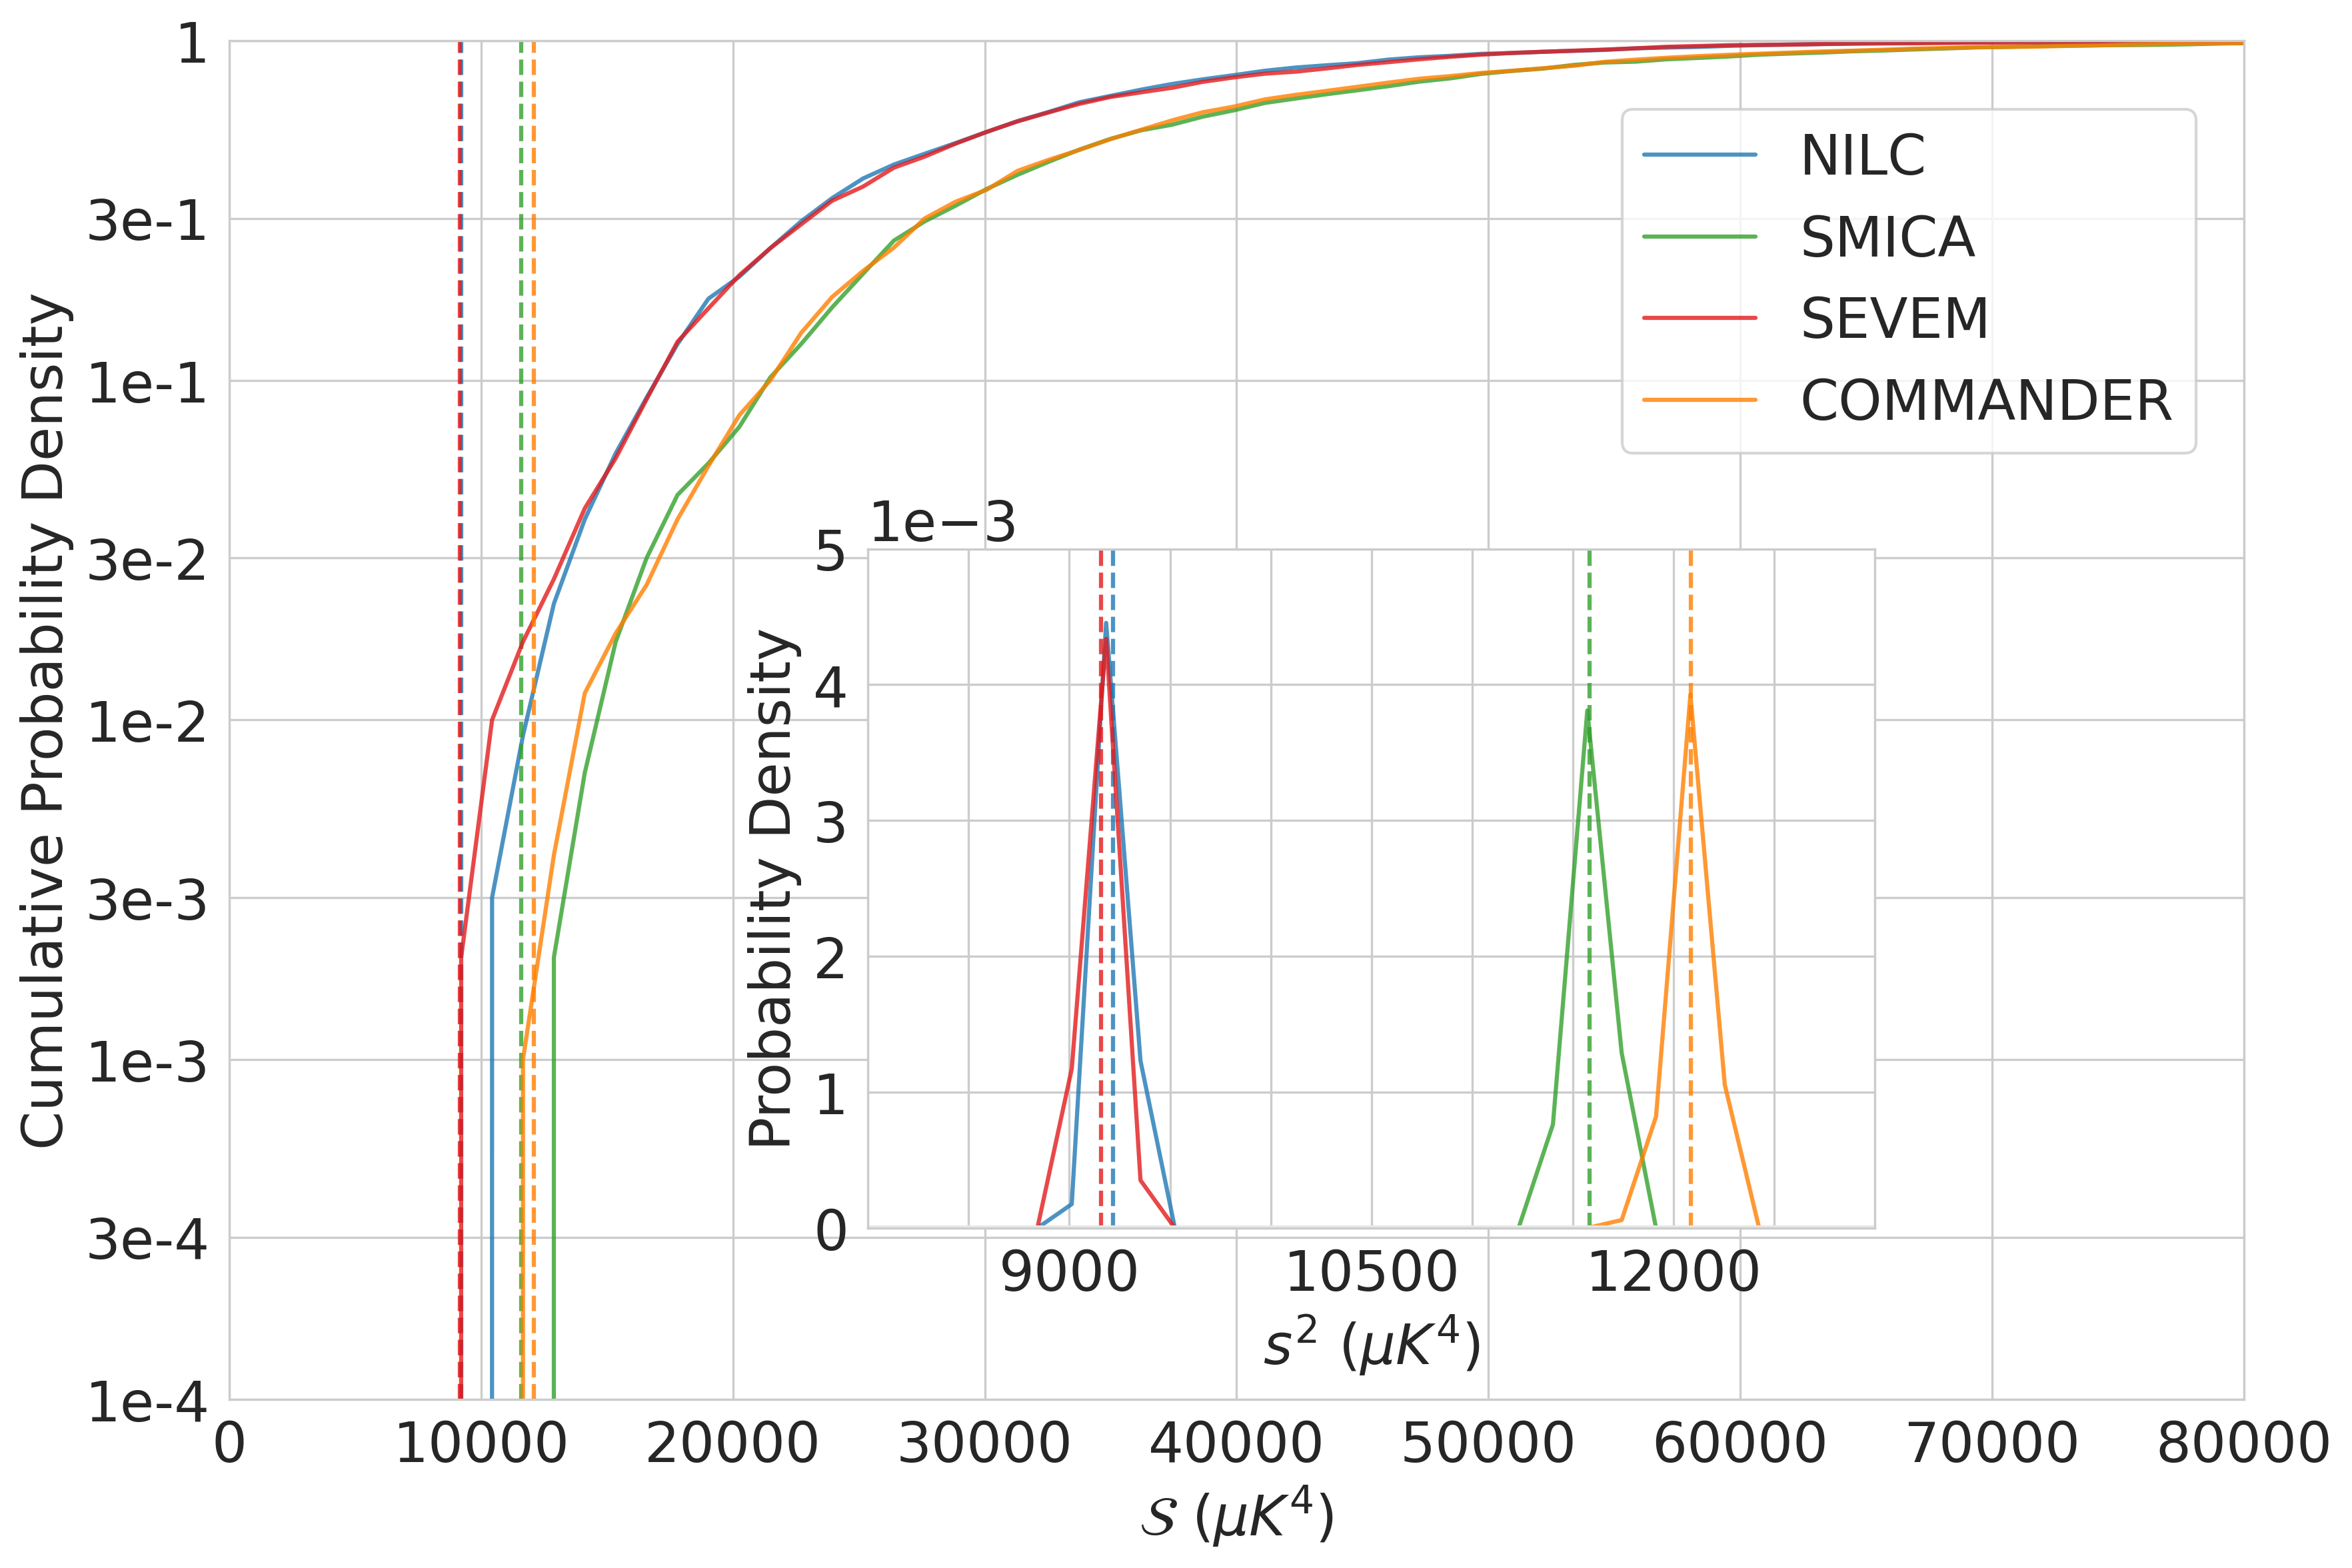

In [81]:
my_file_name = FIGURE_FOLDER_PATH + 'preferred.png'
same_cls_variance_plot_with_inset(vars_of_vars_sims_same_cls[0], monte_carlo_var_of_vars_pref.T, my_file_name)

In [ ]:
if NEW_ROUTINES:
    alms_sims_same_cls_pref, vars_of_vars_sims_same_cls_pref = save_routine(NAMES[2], generate_same_cl_sims, monte_carlo_alms_pref, True, N_SIMS[2])
else:
    alms_sims_same_cls_pref, vars_of_vars_sims_same_cls_pref = load_routine(NAMES[2])

In [46]:
def same_cls_amplitude_plot_with_inset(alms_sims, vars_of_statistics_2, file_name):
    sns.set_style('whitegrid')
    max_value_2 = max(vars_of_statistics_2.flatten()) + 25
    min_value_2 = min(vars_of_statistics_2.flatten()) - 25
    
    simulated_dipole_cls = np.zeros([alms_sims.shape[0], alms_sims.shape[1]])
    real_preferred_dipole_cls = np.zeros(alms_sims.shape[0])
    
    for i in range(alms_sims.shape[0]):
        real_preferred_dipole_cls[i] = hp.alm2cl(monte_carlo_alms_pref[i])[1]
        for j in range(alms_sims.shape[1]):
            simulated_dipole_cls[i][j] = hp.alm2cl(alms_sims[i][j])[1]
    
    fig, ax = plt.subplots()
    colors=sns.color_palette('Paired')
    max_value = max(max(simulated_dipole_cls.flatten()), max(real_preferred_dipole_cls)) + 100
    
    for i in range(4):
        n, bins, _ = ax.hist(simulated_dipole_cls[i], cumulative=-1, density=True, range=(0, max_value), bins = 50, alpha = 0.0)
        my_histr = []
        for j in range(len(bins) - 1):
            my_histr.append((bins[j + 1] + bins[j])/2)
        plt.plot(my_histr, n, color=colors[2*i + 1], label=map_names[i], alpha=0.8)
        ax.axvline(real_preferred_dipole_cls[i], color=colors[2*i+1], alpha=0.8, ls='--')
    
    ax.axhline(0, color=[0.91, 0.91, 0.91], linewidth=2)
    ax.set_xlabel(r'$C_p$ $(\mu K^2)$')
    ax.set_ylabel(r'$1 -$ Cumulative Probability Density')
    ax.legend(fontsize=20)
    ax.set_yscale('log')
    ax.set_xlim([0, 600])
    ax.set_ylim([0.01, 1])
    my_ticks = [0.0100, 0.02500, 0.0500, 0.1, 0.25, 0.50, 1.000]
    ax.set_yticks(my_ticks)

    ax.set_yticklabels(map(str, my_ticks))
    
    my_ticks_str = ['0.010', '0.025', '0.050', '0.100', '0.250', '0.500', '1.000']
    ax.set_yticklabels(my_ticks_str)

    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax, [0.121,0.14,0.3,0.3])
    ax2.set_axes_locator(ip)

    for i in range(4):
        n, bins, _ = ax2.hist(vars_of_statistics_2[i], density=True, range=(min_value_2, max_value_2), bins=30, alpha=0.0)
        my_histr = []
        for j in range(len(bins) - 1):
            my_histr.append((bins[j + 1] + bins[j])/2)
        ax2.plot(my_histr, n, color=colors[2*i+1], label=map_names[i], alpha=0.8)
        ax2.axvline(np.mean(vars_of_statistics_2[i]), color=colors[2*i+1], alpha=0.8, ls='--')
        
    ax2.axhline(0, color=[0.91, 0.91, 0.91], linewidth=2)
    ax2.set_xlim([min_value_2, max_value_2])
    ax2.set_ylim([0, ax2.get_ylim()[1]*1.05])
    ax2.set_xlabel(r'$C_p$ $(\mu K^2)$')
    ax2.set_ylabel('Probability Density')

    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.savefig(file_name)
    plt.show()

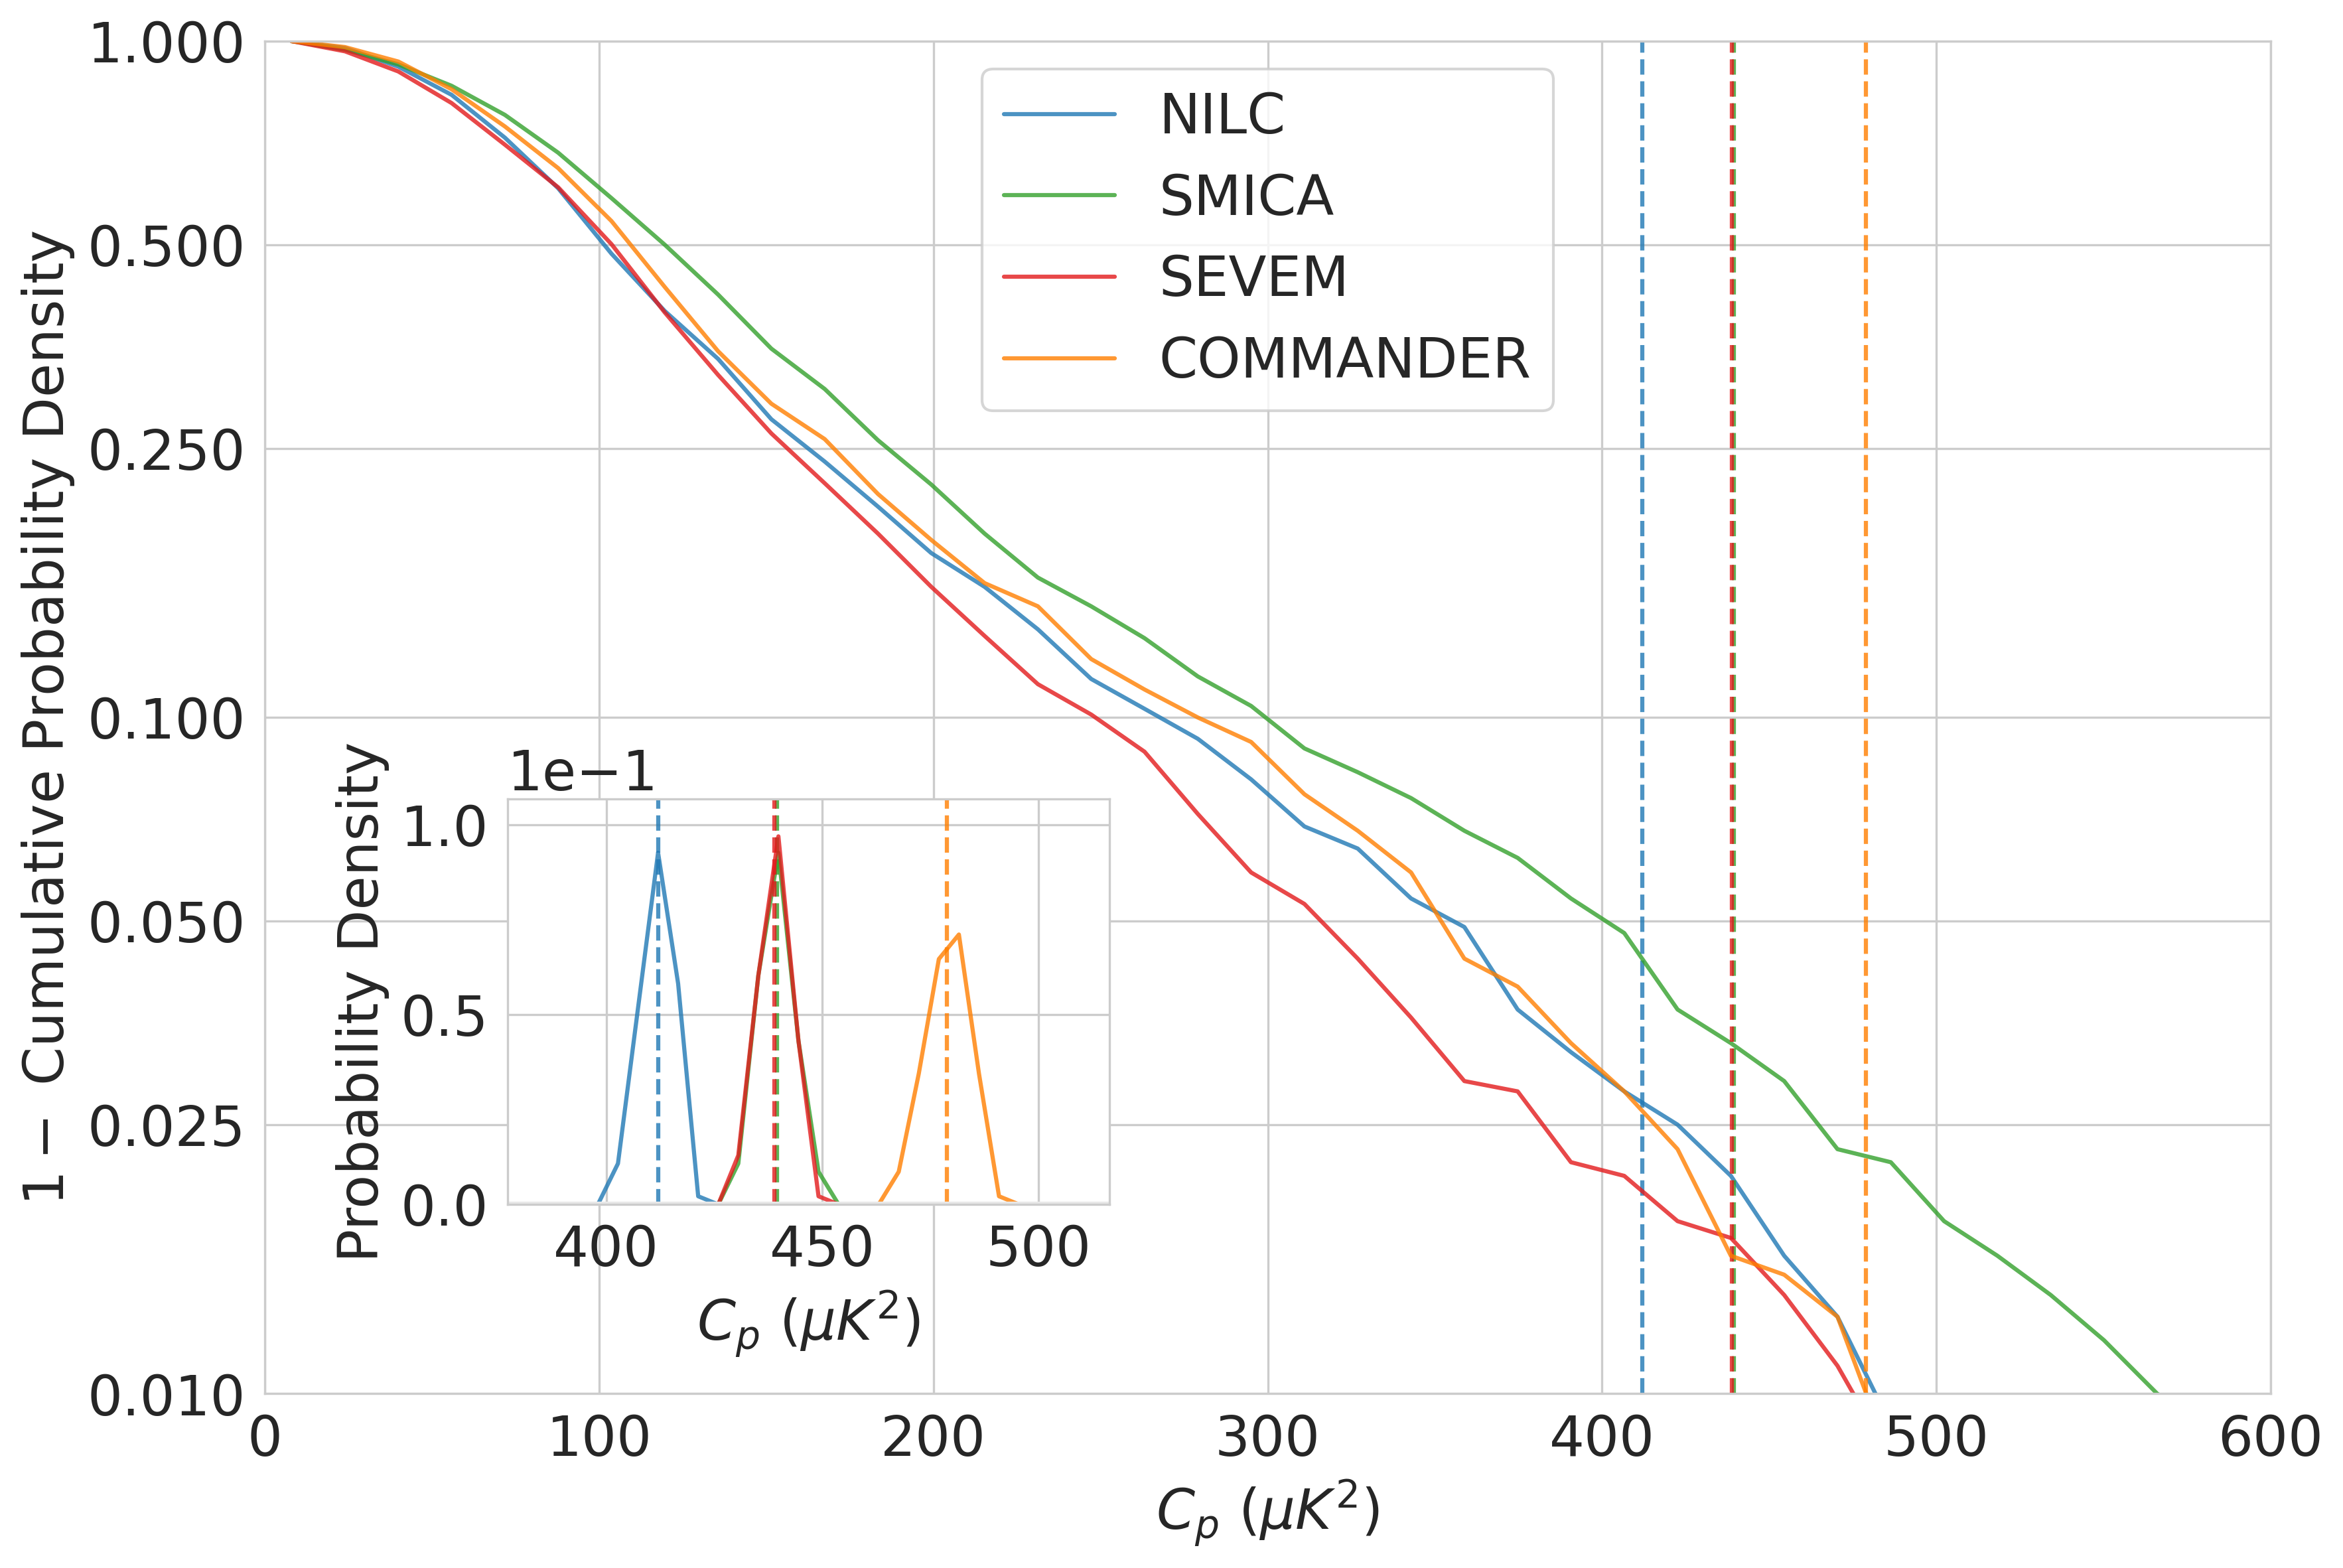

In [47]:
my_file_name = FIGURE_FOLDER_PATH + 'amplitude.png'
same_cls_amplitude_plot_with_inset(alms_sims_same_cls_pref, monte_carlo_dipole_cls.T, my_file_name)